In [1]:
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import ocelot
from fel import SASE, random_beam, random_geometry, N_ELEMENTS

hidden_rng = np.random.RandomState(1111)

initializing ocelot...


In [2]:
class Optimizer(object):
    def __init__(self, x0):
        """
        Optimizer should accept initial configuration x0
        """
        pass

    def reset(self, ):
        """
        Auxilary method --- resets internal state of the optimizer.
        """
        raise NotImplementedError()
        
    def ask(self,):
        """
        Returns next configuration to probe.
        """
        raise NotImplementedError()
    
    def tell(self, x, f):
        """
        Callback method:
        `x` - configuration returned by `ask()` method (possibly clipped to satisfy bounds),
        `f` - value of the objective function in the point `x`.
        """
        raise NotImplementedError()

In [3]:
class RandomSearch(Optimizer):
    def __init__(self, x0, seed=1122):
        self.x0 = x0
        self.rng = np.random.RandomState(seed=seed)
        
        super(RandomSearch, self).__init__(x0)
    
    def ask(self, ):
        return self.rng.uniform(-1, 1, size=self.x0.shape)
    
    def tell(self, x, f):
        pass
    
    def reset(self,):
        pass

In [4]:
class GreedySearch(Optimizer):
    def __init__(self, x0, scale=1e-2, seed=1122):
        self.x0 = x0
        self.rng = np.random.RandomState(seed=seed)
        
        self.x = x0
        self.f = None
        
        self.scale = scale
        
        super(GreedySearch, self).__init__(x0)
    
    def ask(self, ):
        return self.x + self.rng.normal(size=self.x.shape, scale=self.scale)
    
    def tell(self, x, f):
        if self.f is None:
            self.f = f
            self.x = x

        elif self.f < f:
            pass

        else:
            self.f = f
            self.x = x
    
    def reset(self,):
        self.x = self.x0
        self.f = None

In [5]:
sase = SASE(random_beam(hidden_rng), random_geometry(hidden_rng))
epsilon = 1e-12

objective = lambda x: np.log(1e-3) - np.log(sase.rho_int(x) + epsilon)

bounds = np.stack([
    -2 * np.ones(sase.ndim()),
    2 * np.ones(sase.ndim())
], axis=1)

x0 = np.zeros(sase.ndim())

In [6]:
%%timeit
objective(np.random.uniform(-1, 1, size=sase.ndim()))

1.16 s ± 6.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
def eval_optimization(
    optimizer_class, f, x0, bounds,
    moving_cost=1, measuring_cost=1, budget=128,
    progress=None
):
    if progress is None:
        progress = lambda x: x
    
    optimizer = optimizer_class(x0)    
    
    current_x = np.zeros_like(x0)
    
    history_x = list()
    history_f = list()
    
    max_iterations = int(np.floor(budget / measuring_cost))
    
    for _ in progress(range(max_iterations)):
        x = optimizer.ask()
        x = np.array(x, dtype=np.float64)        
        assert x.shape == x0.shape
        
        x = np.clip(x, bounds[:, 0], bounds[:, 1])

        distance = np.max(np.abs(current_x - x))
        
        cost = moving_cost * distance + measuring_cost
        
        if budget < cost:
            break
        
        budget -= cost
        value = f(x)
        current_x = x
        
        optimizer.tell(x, value)
        
        history_x.append(np.copy(x))
        history_f.append(np.copy(value))
    
    return np.array(history_x), np.array(history_f)

In [8]:
from scipy import optimize

solution = optimize.minimize(
    objective,
    x0=x0,
    method='Powell',
    options=dict(maxfev=128),
    bounds=bounds
)

In [9]:
solution.message

'Maximum number of function evaluations has been exceeded.'

In [10]:
print(solution.fun)
print(solution.x)

1.0589204290664744
[ 1.63025372 -1.20286725  0.06612919  0.84702465 -0.43247678  0.11095409
  0.0911893   0.12931333  0.05069228  0.1193649 ]


In [11]:
def cummin(fs):
    result = np.zeros_like(fs)
    
    result[0] = fs[0]
    
    for i in range(1, fs.shape[0]):
        if result[i - 1] < fs[i]:
            result[i] = result[i - 1]
        else:
            result[i] = fs[i]
    
    return result

In [12]:
xs, fs = eval_optimization(
    GreedySearch,
    objective,
    x0=x0,
    bounds=bounds,
    progress=tqdm
)

np.min(fs)

1.7332396557746659

Text(0.5, 0, 'iteration')

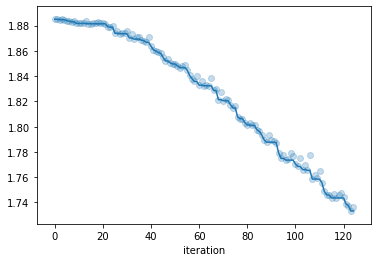

In [13]:
plt.plot(cummin(fs))
plt.scatter(np.arange(fs.shape[0]), fs, alpha=0.25)
plt.xlabel('iteration')

In [14]:
xs, fs = eval_optimization(
    RandomSearch,
    objective,
    x0=x0,
    bounds=bounds,
    progress=tqdm
)

np.min(fs)

1.3451432472090001

Text(0.5, 0, 'iteration')

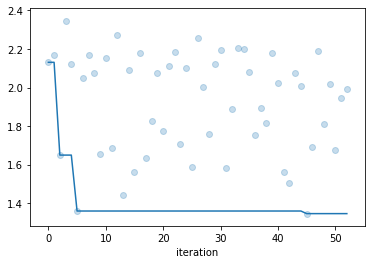

In [15]:
plt.plot(cummin(fs))
plt.scatter(np.arange(fs.shape[0]), fs, alpha=0.25)
plt.xlabel('iteration')